### Problem Statement & Objective
Problem Statement: 
E-commerce businesses generate vast amounts of transactional data but often struggle to leverage it for actionable customer segmentation. Understanding purchasing patterns is crucial for predicting behavior, improving retention, reducing churn, and maximizing customer lifetime value. A structured approach is needed to identify high-value customers, detect trends, and optimize targeted marketing strategies.


Objective:
1. Utilize the RFM (Recency, Frequency, Monetary) framework to segment e-commerce customers.
2. Analyze purchasing patterns to identify high-value customers and at-risk segments.
3. Create targeted marketing strategies to improve customer retention and satisfaction.

### Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

### Loading the Data

In [2]:
df = pd.read_csv('../Dataset/ecomm_data.csv',encoding='ISO-8859-1')

### Exploring the data

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12-09-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12-09-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12-09-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12-09-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12-09-2011 12:50,4.95,12680.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Insights
1. As we can see there are missing values in 'Description' & 'CustomerID' columns
2. CustomerID, UnitPrice and Quantity are numerical columns
3. InvoiceDate is of object datatype and should be converted into Datetime

In [6]:
df.shape

(541909, 8)

### Summary Statistics

In [7]:
df.describe() #For Numerical Variables

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


#### Insights
1. The minimum value for Quantity and UnitPrice are negative, which we will handle later
2. The Standard Deviation for the columns is also very high, which means there is large variation in the data
3. The mean value is also greater than the median value, which means the dataset is right-skwed due to outliers which can also be seen from the min and the max values

In [8]:
df.describe(include='object') # For Categorical Variables

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


#### Insights
1. This ecommerce store operates in 38 countries
2. The unique number of InvoiceNo is much less than the count, which means that multiple orders are placed using a single InvoiceNo
3. The unique number of StockCode is less than the unique number of Description. Some products may have multiple description

#### Handling Missing Values

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
missing_percent = round((df['CustomerID'].isnull().sum()*100)/len(df),2)
print(f"The % of missing values in the CustomerID column is {missing_percent} %")

The % of missing values in the CustomerID column is 24.93 %


Since this analysis will revolve around investigating the customer behaviour and clustering them into categories, the missing values in the CustomerID column should be removed. As removing it will also effect the size of the dataset

In [11]:
# Removing null-values from the CustomerID column
df = df.dropna(subset=['CustomerID'])

In [12]:
# Verfiying the removal of the null values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### Insight
Removing the null values from the CustomerID also removes the null values from the Description column

In [13]:
# Checking the shape
df.shape

(406829, 8)

#### Handling Duplicates

In [14]:
df.duplicated().sum()

np.int64(5225)

In [15]:
df[df.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12-01-2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12-01-2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12-01-2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12-01-2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12-01-2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12-09-2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12-09-2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12-09-2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12-09-2011 11:34,2.10,14446.0,United Kingdom


In [16]:
#Dropping the duplicates and keeping the first occurence
df.drop_duplicates(inplace=True)

In [17]:
# Resetting the index after dropping the duplicates
df.reset_index(drop=True, inplace=True)

In [18]:
# Checking the shape after dropping the duplicate
df.shape

(401604, 8)

In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


#### Removing orders with qunatity < 0

In [20]:
df[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12-01-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12-01-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12-01-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12-01-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12-01-2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
401159,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12-09-2011 09:57,0.83,14397.0,United Kingdom
401243,C581499,M,Manual,-1,12-09-2011 10:28,224.69,15498.0,United Kingdom
401410,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12-09-2011 11:57,10.95,15311.0,United Kingdom
401411,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12-09-2011 11:58,1.25,17315.0,United Kingdom


#### If we look at the InvoiceNo column all of them starts with the letter 'C', which suggests that it is a Cancelled orders

In [21]:
# Storing the negative quantity orders / cancelled orders in another df (if requried in future for any analysis)
df_cancelled = df[df['Quantity'] < 0]

In [22]:
df_cancelled.shape

(8872, 8)

In [23]:
# Keeping only the orders with >= 0 quantity
df = df[df['Quantity'] >= 0]

In [24]:
# Checking the shape of the original dataframe
df.shape

(392732, 8)

In [25]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822
std,181.588420,22.240725,1713.567773
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


#### Visualizing the Quantity

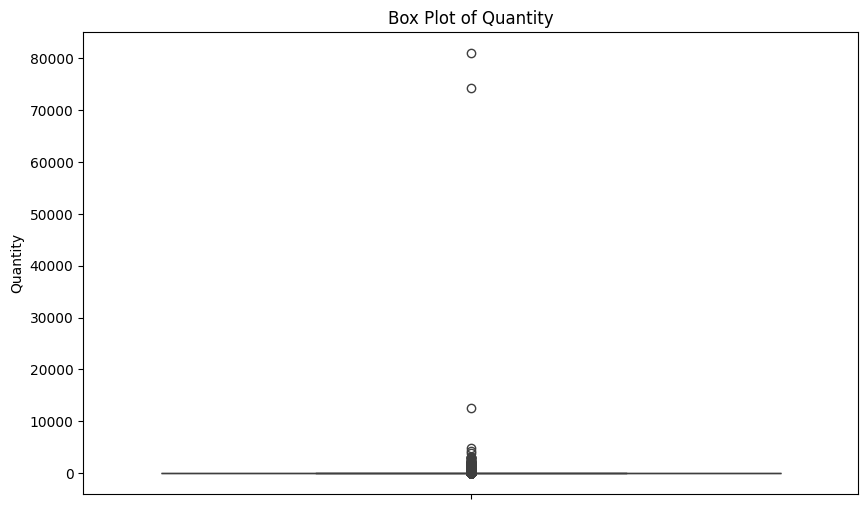

In [26]:
plt.figure(figsize=(10,6))
sns.boxplot(y=df['Quantity'])
plt.title('Box Plot of Quantity')
plt.ylabel('Quantity')
plt.show()

#### Insights
1. There are outliers present in the Quantity column with value as 80995, which should be checked
2. If the Outliers are to be removed then,
   IQR = Q3 - Q1 = 12 - 2 = 10

   Outliers > Q3 + (1.5 * IQR) 
    =  Outliers > 12 + 15 = 27

In [27]:
# Checking the order with the quantity 80995
df[df['Quantity'] == 80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
401131,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12-09-2011 09:15,2.08,16446.0,United Kingdom


In [28]:
# Checking if the customer 16446 has ordered anything else
df[df['CustomerID'] == 16446.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
135450,553573,22980,PANTRY SCRUBBING BRUSH,1,5/18/2011 9:52,1.65,16446.0,United Kingdom
135451,553573,22982,PANTRY PASTRY BRUSH,1,5/18/2011 9:52,1.25,16446.0,United Kingdom
401131,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12-09-2011 09:15,2.08,16446.0,United Kingdom


The customer with ID 16446 has placed a totoal of 3 orders. But the other 2 orders have only 1 quantity

In [29]:
# Excluding some of the outliers
df2 = df[df['Quantity'] < 50]
df2.shape

(380234, 8)

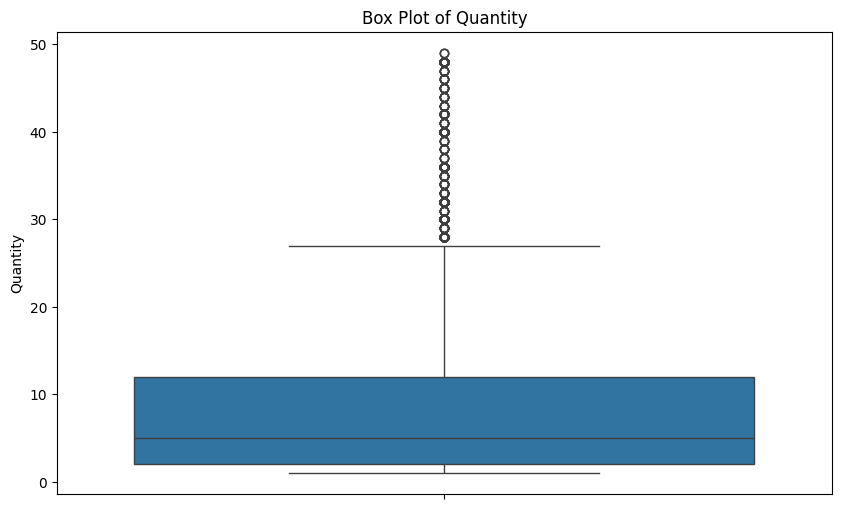

In [30]:
# Boxplot after excluding the outliers
plt.figure(figsize=(10,6))
sns.boxplot(y=df2['Quantity'])
plt.title('Box Plot of Quantity')
plt.ylabel('Quantity')
plt.show()

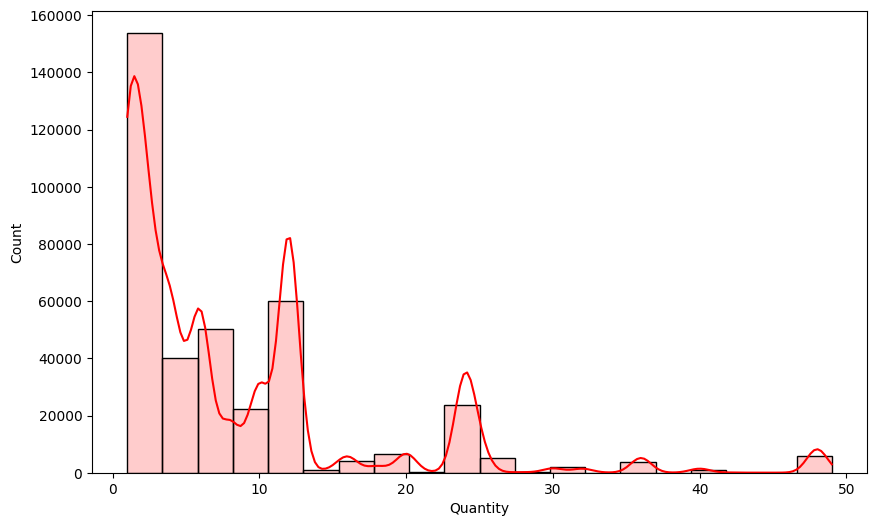

In [31]:
# Histplot for checking the distribution of orders
plt.figure(figsize=(10,6))
sns.histplot(df2['Quantity'], bins=20, kde=True, color='red',alpha=0.2)
plt.show()

#### Insights: 
As we can see most of orders contains less no. of quantities. The one with larger quantities are significantly low

#### Exploring Unit Price

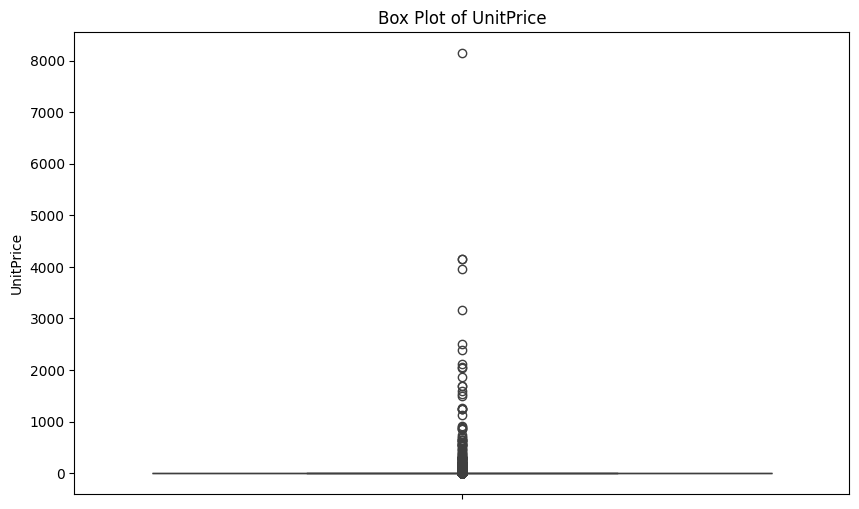

In [32]:
# Boxplot for Unit Price
plt.figure(figsize=(10,6))
sns.boxplot(y=df['UnitPrice'])
plt.title('Box Plot of UnitPrice')
plt.ylabel('UnitPrice')
plt.show()

#### Insights:
1. There are outliers present in the UnitPrice coluumn. The maximum value of price is 8142.75 which should be checked
2. If we want to remove the outliers:
   IQR = Q3 - Q1 = 3.75 - 1.25 = 2.50

   Outliers > Q3 + (1.5 * IQR) = 3.75 + (1.5 * 2.5) = 3.75 + 3.75 = 7.5

In [33]:
# Checking the max value of UnitPrice
df[df['UnitPrice'] == 8142.75]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
119907,551697,POST,POSTAGE,1,05-03-2011 13:46,8142.75,16029.0,United Kingdom


This amount is paid for the Postage(courier charges) as mentioned in the description.
We need to find such StockCode which are not products and need to be dropped from the dataset

In [34]:
df3 = df[df['UnitPrice'] < 10]
df3.shape

(381920, 8)

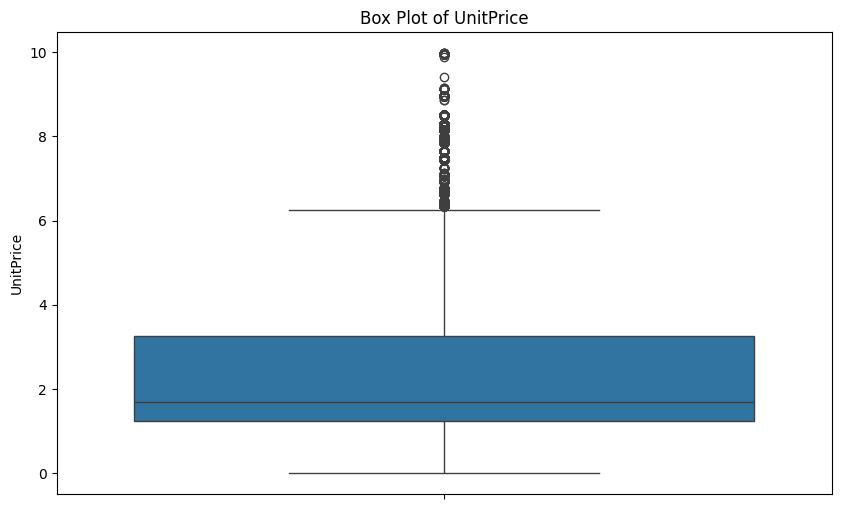

In [38]:
plt.figure(figsize=(10,6))
sns.boxplot(y=df3["UnitPrice"])
plt.title("Box Plot of UnitPrice")
plt.ylabel("UnitPrice")
plt.show()

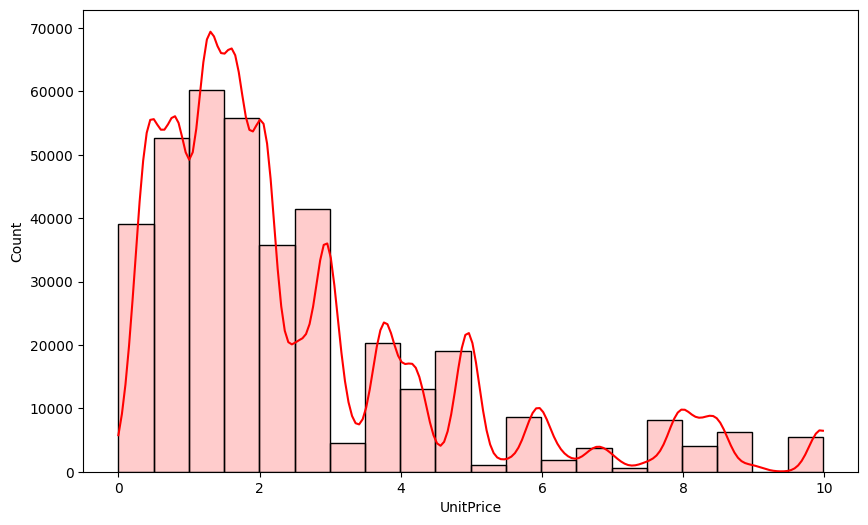

In [39]:
# Distribution of Unit Price
plt.figure(figsize=(10,6))
sns.histplot(df3["UnitPrice"], bins=20, color="red", kde=True, alpha=0.2)
plt.show()

#### Insight: 
Most of the orders are low priced products

#### Exploring InvoiceDate

In [40]:
df['InvoiceDate'].dtype

dtype('O')

In [41]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df['InvoiceDate'].dtype)

ValueError: time data "12/13/2010 9:02" doesn't match format "%m-%d-%Y %H:%M", at position 813. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

We get this error because the dates are in the format: 05-03-2011 13:46 and 5/18/2011 9:52. So we have to transform them into a consistent format before changing the data type

In [43]:
from dateutil import parser
df['InvoiceDate'] = df['InvoiceDate'].apply(lambda x: parser.parse(x) if pd.notnull(x) else pd.NaT)

In [44]:
print(df['InvoiceDate'].dtype)

datetime64[ns]


In [45]:
# First and last order date
print('First Order Date:', df['InvoiceDate'].min())
print('Last Order Date:', df['InvoiceDate'].max())

First Order Date: 2010-12-01 08:26:00
Last Order Date: 2011-12-09 12:50:00


The orders from this ecommerce store is slightly over one year

#### Exploring Stock Code

In [47]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Insight: 
The StockCode are of 2 different types
1. Numeric
2. Alpha Numeric

In [48]:
df['StockCode'] = df['StockCode'].astype('str')
df[df['StockCode'].str.isnumeric()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
401599,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
401600,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
401601,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
401602,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [49]:
df.shape

(392732, 8)

#### Insight: 
Out of 392732 StockCodes, 358309 StockCodes are numeric

In [50]:
# Filter the Stock Codes that are entirely numeric
numeric_stockcodes = df[df['StockCode'].str.isnumeric()]

In [51]:
numeric_stockcodes.shape

(358309, 8)

In [52]:
# Calculate the length of each stockcodes
numeric_stockcodes['Length'] = numeric_stockcodes['StockCode'].str.len()

# Group by the lenght and count their occurences
length_counts = numeric_stockcodes['Length'].value_counts().sort_index()

#Check the length
print(length_counts)

Length
5    358309
Name: count, dtype: int64


#### Insight:
All numeric StockCodes have length 5

In [53]:
# Check the alphanumeric StockCodesd
df[~df['StockCode'].str.isnumeric()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France
...,...,...,...,...,...,...,...,...
401473,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2011-12-09 12:16:00,4.15,12713.0,Germany
401504,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2011-12-09 12:19:00,1.79,17581.0,United Kingdom
401533,581580,84993A,75 GREEN PETIT FOUR CASES,2,2011-12-09 12:20:00,0.42,12748.0,United Kingdom
401539,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,2011-12-09 12:20:00,1.25,12748.0,United Kingdom


#### Insight: 
Out of 392732 StockCodes, 34423 StockCodes are alphanumeric

In [54]:
# Filter the StockCode that are entirely alphanumeric
alphanumeric_stockcodes = df[~df['StockCode'].str.isnumeric()]

In [55]:
alphanumeric_stockcodes.shape

(34423, 8)

In [56]:
# Calculate the length of each numeric StockCode
alphanumeric_stockcodes['Length'] = alphanumeric_stockcodes['StockCode'].str.len()

# Group by the each length and count their occurences
length_counts = alphanumeric_stockcodes['Length'].value_counts().sort_index()

# Check the lenghts
print(length_counts)

Length
1       285
2       133
3        16
4      1103
6     32583
7       291
12       12
Name: count, dtype: int64


#### Insight: 
The alphanumeric StockCodes have different lengths: 1,2,3,4,6,7,12

In [57]:
#Creating a column in the original dataframe to store the lengths of the StockCodes
df['len_sc'] = df['StockCode'].str.len()
df['len_sc'].value_counts()

len_sc
5     358309
6      32583
4       1103
7        291
1        285
2        133
3         16
12        12
Name: count, dtype: int64

In [58]:
# Check the StockCodes which have lenghts less than 5
df[(df['len_sc'] < 5)]['StockCode'].value_counts()

StockCode
POST    1099
M        285
C2       133
DOT       16
PADS       4
Name: count, dtype: int64

In [59]:
df_sc = df[(df['len_sc'] < 5)][['StockCode', 'Description']].drop_duplicates()
df_sc

,StockCode,Description
45,POST,POSTAGE
1386,C2,CARRIAGE
1654,M,Manual
108733,PADS,PADS TO MATCH ALL CUSHIONS
228469,DOT,DOTCOM POSTAGE


In [60]:
df[df['StockCode'] == 'PADS']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_sc
108733,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,13952.0,United Kingdom,4
197044,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,15618.0,United Kingdom,4
259711,568158,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 12:22:00,0.000,16133.0,United Kingdom,4
260900,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 14:58:00,0.001,16198.0,United Kingdom,4


#### Insight: 
The StockCodes having length less than 5, are not valid products. The UnitPrice of the PADS is so less that removing it will not affect our analysis. 

And we will also drop the StockCodes with length less than 5

In [61]:
df[(df['len_sc'] > 7)]['StockCode'].value_counts()

StockCode
BANK CHARGES    12
Name: count, dtype: int64

#### Insight: 
The StockCode having length 12 is 'BANK CHARGES' which can be safely dropped from the dataset

In [62]:
df[(df['len_sc'] == 7)]['StockCode'].value_counts()

StockCode
15056BL    291
Name: count, dtype: int64

In [63]:
df[df['StockCode'] == '15056BL']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_sc
132,536381,15056BL,EDWARDIAN PARASOL BLACK,2,2010-12-01 09:41:00,5.95,15311.0,United Kingdom,7
281,536396,15056BL,EDWARDIAN PARASOL BLACK,6,2010-12-01 10:51:00,4.95,17850.0,United Kingdom,7
1183,536531,15056BL,EDWARDIAN PARASOL BLACK,12,2010-12-01 13:23:00,5.95,15485.0,United Kingdom,7
2952,536750,15056BL,EDWARDIAN PARASOL BLACK,6,2010-12-02 14:04:00,4.95,17850.0,United Kingdom,7
2973,536752,15056BL,EDWARDIAN PARASOL BLACK,6,2010-12-02 14:06:00,4.95,17850.0,United Kingdom,7
...,...,...,...,...,...,...,...,...,...
393596,580727,15056BL,EDWARDIAN PARASOL BLACK,1,2011-12-05 17:17:00,12.46,14096.0,United Kingdom,7
395001,580893,15056BL,EDWARDIAN PARASOL BLACK,1,2011-12-06 12:38:00,5.95,17290.0,United Kingdom,7
396816,581098,15056BL,EDWARDIAN PARASOL BLACK,6,2011-12-07 11:42:00,5.95,14911.0,EIRE,7
398622,581232,15056BL,EDWARDIAN PARASOL BLACK,24,2011-12-08 10:26:00,5.95,12358.0,Austria,7


In [64]:
df[(df['len_sc'] == 5)]['StockCode'].value_counts()

StockCode
22423    1714
84879    1395
47566    1390
20725    1304
22720    1152
         ... 
90104       1
90071       1
90054       1
21839       1
20703       1
Name: count, Length: 2785, dtype: int64

In [65]:
df[(df['len_sc'] == 6)]['StockCode'].value_counts()

StockCode
85123A    2023
85099B    1615
82494L     816
85099F     656
85099C     656
          ... 
90141D       1
90214T       1
90214U       1
90214W       1
90214Z       1
Name: count, Length: 873, dtype: int64

#### Insight: 
The StockCodes with length 5,6,7 are vaild and we will keep them

In [66]:
# Removing all the anomalies in the StockCode of length 1,2,4,12
# And keeping only the StockCodes having lenght 5,6,7
df = df[(df['len_sc'] >=5) & (df['len_sc'] < 8)]
df['len_sc'].value_counts()

len_sc
5    358309
6     32583
7       291
Name: count, dtype: int64

In [67]:
df.shape

(391183, 9)

In [68]:
# Removing the len_sc column
df = df.drop('len_sc', axis=1)
df.shape

(391183, 8)

#### Exploring Description

In [69]:
df[['StockCode', 'Description']].describe()

,StockCode,Description
count,391183,391183
unique,3659,3871
top,85123A,WHITE HANGING HEART T-LIGHT HOLDER
freq,2023,2016


#### Insight: 
The unique values of StockCodes and Descriptions are still different. So there exists some products for which they have more than one description. Lets investigate those. 

In [70]:
# Identify stock codes with more than one unique description
duplicates = df.groupby('StockCode')['Description'].nunique()
duplicates = duplicates[duplicates > 1].index

In [71]:
# Filter the rows that have these stock codes
duplicate_rows = df[df['StockCode'].isin(duplicates)]

In [72]:
# Sort the result by StockCode
duplicate_rows_sorted = duplicate_rows[['StockCode', 'Description']].sort_values(by='StockCode')

# View the result
print(duplicate_rows_sorted.drop_duplicates())

       StockCode                          Description
70712     16156L                       WRAP, CAROUSEL
196026    16156L                        WRAP CAROUSEL
134524    17107D  FLOWER FAIRY,5 SUMMER B'DRAW LINERS
360341    17107D         FLOWER FAIRY 5 DRAWER LINERS
251446    17107D    FLOWER FAIRY 5 SUMMER DRAW LINERS
...          ...                                  ...
332361    90014A         SILVER M.O.P. ORBIT NECKLACE
134637    90014B         GOLD M PEARL  ORBIT NECKLACE
283326    90014B           GOLD M.O.P. ORBIT NECKLACE
218418    90014C          SILVER/BLACK ORBIT NECKLACE
376110    90014C      SILVER AND BLACK ORBIT NECKLACE

[445 rows x 2 columns]


#### Insights: 
The descriptions are basically same but there are some data entry errors. In some cases, multiple descriptions
of a specific product are different because of an extra comma or space or a new word. We can choose to ignore this situation 
as we will use StockCodes for product analysis. 

#### Exploring CustomerID

In [73]:
df['CustomerID'].nunique()

4335

#### Insight: 
There are 4335 unique customer as per our analysis

In [74]:
df['CustomerID'].value_counts()

CustomerID
17841.0    7667
14911.0    5586
14096.0    5095
12748.0    4397
14606.0    2674
           ... 
14576.0       1
12791.0       1
13747.0       1
18174.0       1
13017.0       1
Name: count, Length: 4335, dtype: int64

#### Exploring Country

In [75]:
df['Country'].nunique()

37

In [76]:
df['Country'].value_counts()

Country
United Kingdom          348892
Germany                   8644
France                    8019
EIRE                      7128
Spain                     2418
Netherlands               2326
Belgium                   1935
Switzerland               1811
Portugal                  1416
Australia                 1183
Norway                    1049
Channel Islands            743
Italy                      741
Finland                    647
Cyprus                     601
Sweden                     427
Austria                    384
Denmark                    367
Poland                     325
Japan                      321
Israel                     245
Unspecified                241
Singapore                  215
Iceland                    182
USA                        179
Canada                     150
Greece                     142
Malta                      109
United Arab Emirates        67
European Community          57
RSA                         57
Lebanon                     45


#### Exploring InvoiceNo

In [77]:
df['InvoiceNo'].nunique()

18405

In [78]:
df['InvoiceNo'].value_counts()

InvoiceNo
576339    541
579196    532
580727    528
578270    441
573576    434
         ... 
578286      1
578311      1
578300      1
551888      1
545790      1
Name: count, Length: 18405, dtype: int64

### Time Series Analysis

In [79]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [80]:
df.shape

(391183, 8)

In [81]:
# Creating a new column 'Total Sales'
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

In [82]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [83]:
df['TotalSales'].describe()

count    391183.000000
mean         22.335397
std         310.919394
min           0.000000
25%           4.950000
50%          11.900000
75%          19.800000
max      168469.600000
Name: TotalSales, dtype: float64

#### Insight: 
Most of the orders are of low value

In [84]:
# We will use this dataframe for the rest Time-Series Analysis
time_series_df = df.copy()
time_series_df.shape

(391183, 9)

#### Daily Sales Over Time

In [85]:
time_series_df['InvoiceDate'] = time_series_df['InvoiceDate'].dt.date
time_series_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [86]:
daily_sales = time_series_df.groupby('InvoiceDate')['TotalSales'].sum().reset_index()
daily_sales

,InvoiceDate,TotalSales
0,2010-12-01,46035.29
1,2010-12-02,47164.57
2,2010-12-03,23530.93
3,2010-12-05,30905.32
4,2010-12-06,30807.90
...,...,...
300,2011-12-05,55799.48
301,2011-12-06,45429.81
302,2011-12-07,68575.60
303,2011-12-08,50090.70


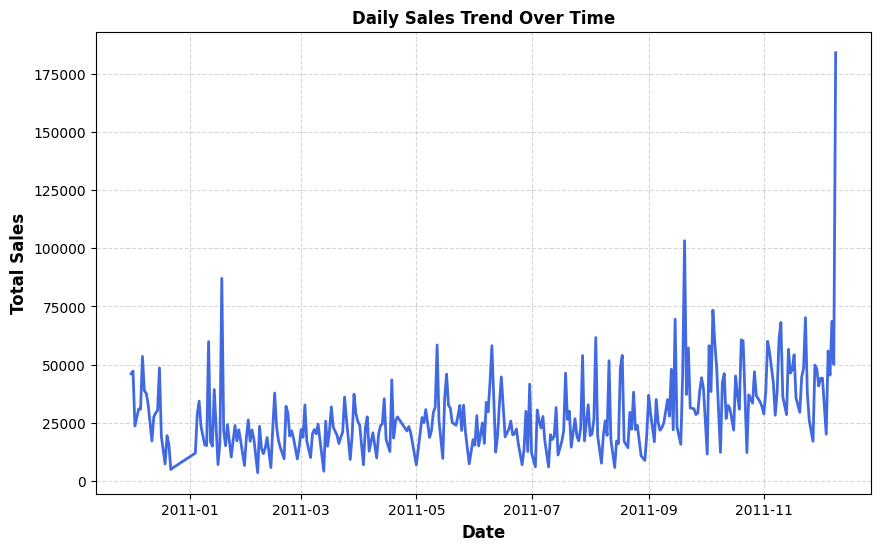

In [88]:
# Plot the daily sales chart
# Set the figure size
plt.figure(figsize=(10,6))

# line plot
sns.lineplot(data=daily_sales, x='InvoiceDate', y='TotalSales', color='royalblue', linewidth=2)

# Set the labels and title
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Total Sales', fontsize=12, fontweight='bold')
plt.title('Daily Sales Trend Over Time',fontsize=12, fontweight='bold')

# Show the grid
plt.grid(True, linestyle='--',alpha=0.5)

# Show plot
plt.show()

In [89]:
# Resample the sales data monthly and sum up the total sales
monthly_sales = df.resample('M', on='InvoiceDate')['TotalSales'].sum()

# Convert index to formatted string ('Jan 2020')
monthly_sales.index = monthly_sales.index.strftime('%b %Y')

# Display the result
print(monthly_sales)

InvoiceDate
Dec 2010     565199.56
Jan 2011     562682.91
Feb 2011     442293.59
Mar 2011     583143.85
Apr 2011     454440.88
May 2011     659242.49
Jun 2011     653264.92
Jul 2011     591603.79
Aug 2011     635514.38
Sep 2011     938752.63
Oct 2011    1002326.56
Nov 2011    1136534.00
Dec 2011     512228.08
Name: TotalSales, dtype: float64


In [90]:
# Calculate the average monthly sales
print('The Average monthly sales over a period of one year is', round(monthly_sales.values.mean()))

The Average monthly sales over a period of one year is 672094


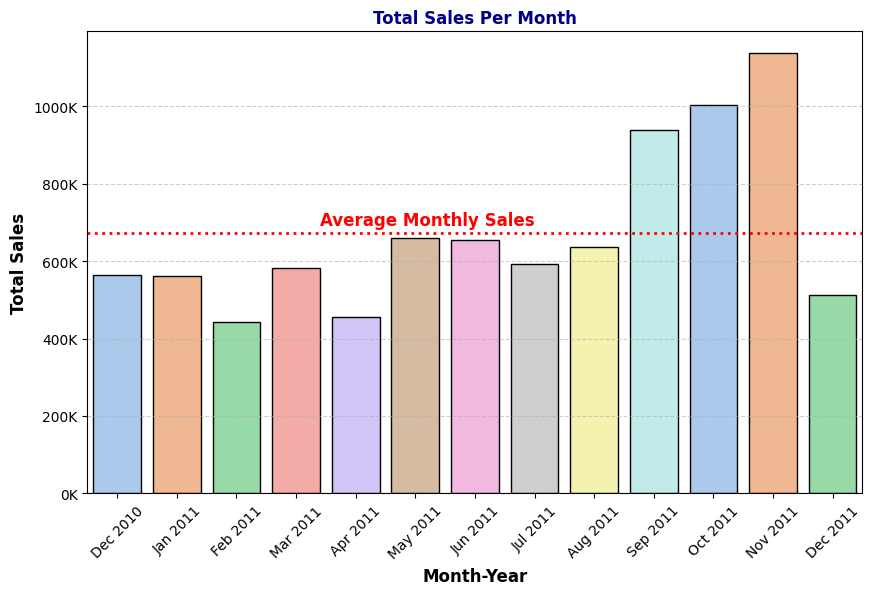

In [95]:
# Plotting the monthly sales
plt.figure(figsize=(10,6))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values, palette='pastel', edgecolor='black')

# Formatting
plt.xlabel('Month-Year', fontsize=12, fontweight='bold')
plt.ylabel('Total Sales', fontsize=12, fontweight='bold')
plt.title('Total Sales Per Month', fontsize=12, fontweight='bold', color='darkblue')

# Format y-axis to show sales in "K" instead of full numbers
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))

# Calculate average monthly sales
average_sales = monthly_sales.values.mean()
# Add a horizontal dotted line for average sales
plt.axhline(average_sales, color="red", linestyle="dotted", linewidth=2, label=f"Avg Sales: {average_sales/1000:.1f}K")

# Add annotation above the average line
plt.text(x=len(monthly_sales) - 6,  # Position near the last bar
         y=average_sales + (average_sales * 0.03),  # Slightly above the line
         s="Average Monthly Sales",
         color="red",
         fontsize=12,
         fontweight="bold",
         ha="right")  # Align to the right

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

#### Insight: 
There is an increase in Total Sales in the months of September, October and November. 

#### Sales by Day

In [96]:
# Extract the day from the datetime
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,DayOfWeek
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday


In [97]:
sales_by_day = df.groupby('DayOfWeek')['TotalSales'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

sales_by_day

DayOfWeek
Monday       1326500.48
Tuesday      1672493.12
Wednesday    1559469.25
Thursday     1939228.91
Friday       1459797.08
Saturday            NaN
Sunday        779738.80
Name: TotalSales, dtype: float64

In [98]:
df[df['DayOfWeek'] == 'Saturday']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,DayOfWeek


There is no sales on Saturday

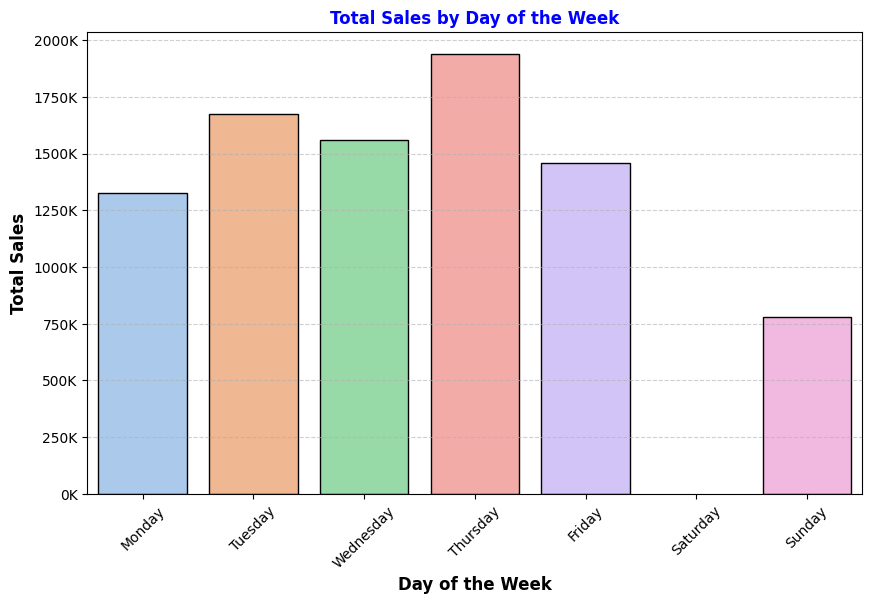

In [99]:
# Set figure size
plt.figure(figsize=(10, 6))

# Create bar plot
sns.barplot(x=sales_by_day.index, y=sales_by_day.values, palette="pastel", edgecolor="black")

# Formatting
plt.xlabel("Day of the Week", fontsize=12, fontweight="bold")
plt.ylabel("Total Sales", fontsize=12, fontweight="bold")
plt.title("Total Sales by Day of the Week", fontsize=12, fontweight="bold", color="blue")

# Format y-axis to show sales in "K" instead of full numbers
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.show()

### Pareto Principle
#### 80% of the Revenue comes from 20% of the total customers

In [101]:
df['CustomerID'].nunique()

4335

In [105]:
# Calcuate total sales per customer
sales_per_customer = df.groupby('CustomerID')['TotalSales'].sum().reset_index()
sales_per_customer = sales_per_customer.sort_values(by='TotalSales',ascending=False).reset_index(drop=True)
sales_per_customer

,CustomerID,TotalSales
0,14646.0,279138.02
1,18102.0,259657.30
2,17450.0,194390.79
3,16446.0,168472.50
4,14911.0,136161.83
...,...,...
4330,17956.0,12.75
4331,14792.0,6.20
4332,16454.0,5.90
4333,16738.0,3.75


In [107]:
# Creating a new column "Cumulative percentage"
sales_per_customer['CumulativePercentage'] = (sales_per_customer['TotalSales'].cumsum()*100)/sales_per_customer['TotalSales'].sum()
sales_per_customer

,CustomerID,TotalSales,CumulativePercentage
0,14646.0,279138.02,3.194812
1,18102.0,259657.30,6.166662
2,17450.0,194390.79,8.391519
3,16446.0,168472.50,10.319734
4,14911.0,136161.83,11.878144
...,...,...,...
4330,17956.0,12.75,99.999819
4331,14792.0,6.20,99.999890
4332,16454.0,5.90,99.999957
4333,16738.0,3.75,100.000000


In [109]:
# Verifying the the Pareto Principle
percentage = round((len(sales_per_customer[sales_per_customer['CumulativePercentage'] < 80])*100)/len(sales_per_customer))
print(f'{percentage}% of customers contribute to 80% of sales')

26% of customers contribute to 80% of sales


#### 20% of Products contribute to 80% of the Revenue

In [110]:
df['StockCode'].nunique()

3659

In [112]:
# Total Sales per product
sales_per_product = df.groupby('StockCode')['TotalSales'].sum().reset_index()
sales_per_product = sales_per_product.sort_values(by='TotalSales',ascending=False).reset_index(drop=True)
sales_per_product

,StockCode,TotalSales
0,23843,168469.60
1,22423,142264.75
2,85123A,100547.45
3,85099B,85040.54
4,23166,81416.73
...,...,...
3654,84201C,0.95
3655,90104,0.85
3656,90084,0.85
3657,21268,0.84


In [114]:
# Creating a new column Cumulative Percentage
sales_per_product['CumulativePercentage'] = (sales_per_product['TotalSales'].cumsum()*100)/sales_per_product['TotalSales'].sum()
sales_per_product

,StockCode,TotalSales,CumulativePercentage
0,23843,168469.60,1.928181
1,22423,142264.75,3.556441
2,85123A,100547.45,4.707235
3,85099B,85040.54,5.680547
4,23166,81416.73,6.612384
...,...,...,...
3654,84201C,0.95,99.999966
3655,90104,0.85,99.999976
3656,90084,0.85,99.999986
3657,21268,0.84,99.999995


In [116]:
# Verifying the Pareto Principle
percentage = round((len(sales_per_product[sales_per_product['CumulativePercentage'] < 80])*100)/len(sales_per_product))
print(f'{percentage}% of products contribute to 80% of sales')

21% of products contribute to 80% of sales


#### 20% of the products contribute to 80% of the sales volume

In [117]:
# Sales volume per product
volume_per_product = df.groupby("StockCode")["Quantity"].sum().reset_index()
volume_per_product = volume_per_product.sort_values(by="Quantity", ascending=False).reset_index(drop=True)
volume_per_product

,StockCode,Quantity
0,23843,80995
1,23166,77916
2,84077,54319
3,22197,49160
4,85099B,46078
...,...,...
3654,22323,1
3655,37461,1
3656,90025F,1
3657,90165B,1


In [118]:
# Creating a new column "CumulativePercentage"
volume_per_product["CumulativePercentage"] = (volume_per_product["Quantity"].cumsum()*100)/volume_per_product["Quantity"].sum()
volume_per_product

,StockCode,Quantity,CumulativePercentage
0,23843,80995,1.570992
1,23166,77916,3.082262
2,84077,54319,4.135842
3,22197,49160,5.089357
4,85099B,46078,5.983093
...,...,...,...
3654,22323,1,99.999922
3655,37461,1,99.999942
3656,90025F,1,99.999961
3657,90165B,1,99.999981


In [119]:
# Verifying the Pareto Principle
percentage = round((len(volume_per_product[volume_per_product["CumulativePercentage"] < 80])*100)/len(volume_per_product))
print(f"{percentage}% of products contribute to 80% of sales volume.")

23% of products contribute to 80% of sales volume.


### RFM Analysis
R- Recency
F- Frequency
M- Monetary

In [121]:
# Get the latest date in the dataset for Recency calculation
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(latest_date)

2011-12-10 12:50:00


### Create a RFM table

In [123]:
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days, #Recency
    'InvoiceNo': 'nunique', #Frequency
    'TotalSales': 'sum' #Monetary
}).reset_index()

rfm_df

,CustomerID,InvoiceDate,InvoiceNo,TotalSales
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,310,1,294.40
...,...,...,...,...
4330,18280.0,278,1,180.60
4331,18281.0,181,1,80.82
4332,18282.0,8,2,178.05
4333,18283.0,4,16,2039.58


In [124]:
# Rename the Columns
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,310,1,294.40


In [125]:
rfm_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,4335.000000,4335.000000,4335.000000,4335.000000
mean,15298.780392,92.684890,4.245675,2015.508106
std,1722.075082,100.172622,7.636337,8902.699230
min,12346.000000,1.000000,1.000000,0.000000
25%,13811.500000,18.000000,1.000000,304.105000
50%,15297.000000,51.000000,2.000000,661.520000
75%,16778.500000,143.000000,5.000000,1631.475000
max,18287.000000,374.000000,206.000000,279138.020000


### Assign RFM Scores

In [126]:
# Rank-based Frequency scoring
rfm_df["F_Rank"] = rfm_df["Frequency"].rank(method="first")
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,F_Rank
0,12346.0,326,1,77183.60,1.0
1,12347.0,2,7,4310.00,3644.0
2,12348.0,75,4,1437.24,2840.0
3,12349.0,19,1,1457.55,2.0
4,12350.0,310,1,294.40,3.0


In [127]:
# Get bin edges for Recency, Frequency (ranked), and Monetary
_, recency_bins = pd.qcut(rfm_df["Recency"], q=5, labels=[5, 4, 3, 2, 1], retbins=True)
_, frequency_bins = pd.qcut(rfm_df["F_Rank"], q=5, labels=[1, 2, 3, 4, 5], retbins=True)
_, monetary_bins = pd.qcut(rfm_df["Monetary"], q=5, labels=[1, 2, 3, 4, 5], retbins=True)

In [128]:
# Convert frequency rank bins to actual frequency values
actual_freq_bins = []
for i in range(len(frequency_bins) - 1):
    lower_rank = frequency_bins[i]
    upper_rank = frequency_bins[i + 1]
    actual_lower = rfm_df.loc[rfm_df["F_Rank"] >= lower_rank, "Frequency"].min()
    actual_upper = rfm_df.loc[rfm_df["F_Rank"] <= upper_rank, "Frequency"].max()
    actual_freq_bins.append(f"{actual_lower} - {actual_upper}")

In [129]:
# Create a DataFrame with readable bin ranges
# Frequency & Monetary bins
rfm_bin_ranges1 = pd.DataFrame({
    "Score": [1,2,3,4,5],
    "Frequency Range (Mapped)": actual_freq_bins,
    "Monetary Range": [f"{int(monetary_bins[i])} - {int(monetary_bins[i+1])}" for i in range(len(monetary_bins)-1)]
})
# Recency bins
rfm_bin_ranges2 = pd.DataFrame({
    "Score": [5,4,3,2,1],
    "Recency Range": [f"{int(recency_bins[i])} - {int(recency_bins[i+1])}" for i in range(len(recency_bins)-1)]
})

In [130]:
# Display the bin ranges
rfm_bin_ranges1

,Score,Frequency Range (Mapped),Monetary Range
0,1,1 - 1,0 - 246
1,2,1 - 2,246 - 482
2,3,2 - 3,482 - 922
3,4,3 - 5,922 - 2028
4,5,5 - 206,2028 - 279138


In [131]:
rfm_bin_ranges2

,Score,Recency Range
0,5,1 - 14
1,4,14 - 33
2,3,33 - 72
3,2,72 - 179
4,1,179 - 374


In [132]:
# Recency Score (lower is better, so reverse the labels)
rfm_df["R_Score"] = pd.qcut(rfm_df["Recency"], q=5, labels=[5, 4, 3, 2, 1])

In [133]:
# Frequency Score (higher is better)
rfm_df["F_Score"] = pd.qcut(rfm_df["Frequency"].rank(method="first"), q=5, labels=[1, 2, 3, 4, 5])

In [134]:
# Monetary Score (higher is better)
rfm_df["M_Score"] = pd.qcut(rfm_df["Monetary"], q=5, labels=[1, 2, 3, 4, 5])

In [136]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,F_Rank,R_Score,F_Score,M_Score
0,12346.0,326,1,77183.60,1.0,1,1,5
1,12347.0,2,7,4310.00,3644.0,5,5,5
2,12348.0,75,4,1437.24,2840.0,2,4,4
3,12349.0,19,1,1457.55,2.0,4,1,4
4,12350.0,310,1,294.40,3.0,1,1,2


#### Segmenting Customers based on the RMF Scores

In [138]:
rfm_df['R_Score'] = rfm_df['R_Score'].astype('int')
rfm_df['F_Score'] = rfm_df['F_Score'].astype('int')
rfm_df['M_Score'] = rfm_df['M_Score'].astype('int')

In [139]:
def rfm_segment(row):
    if row['R_Score'] == 5 and row['F_Score'] == 5:
        return 'High Value'
    if row['R_Score'] >= 4 and row['F_Score'] >=4 :
        return 'Loyal'
    elif row['R_Score'] >= 2 and row['F_Score'] >= 2:
        return 'At-Risk'
    else:
        return 'Dormant'

rfm_df['Segement'] = rfm_df.apply(rfm_segment,axis=1)

In [140]:
rfm_df['Segement'].value_counts()

Segement
At-Risk       1827
Dormant       1372
Loyal          693
High Value     443
Name: count, dtype: int64

In [142]:
# Pivoting the RFM by mean
rfm_pivot = rfm_df.pivot_table(index='R_Score',columns='F_Score',values='M_Score',aggfunc='mean',fill_value=0)
rfm_pivot

F_Score,1,2,3,4,5
R_Score,,,,,
1,1.729282,1.745928,2.550725,3.106383,4.000000
2,1.989950,2.135678,2.903084,3.631902,4.340000
3,1.933333,2.098901,2.888298,3.721154,4.641026
4,1.618557,2.123967,2.824859,3.738956,4.680328
5,1.659091,2.431034,2.781022,3.755000,4.762980


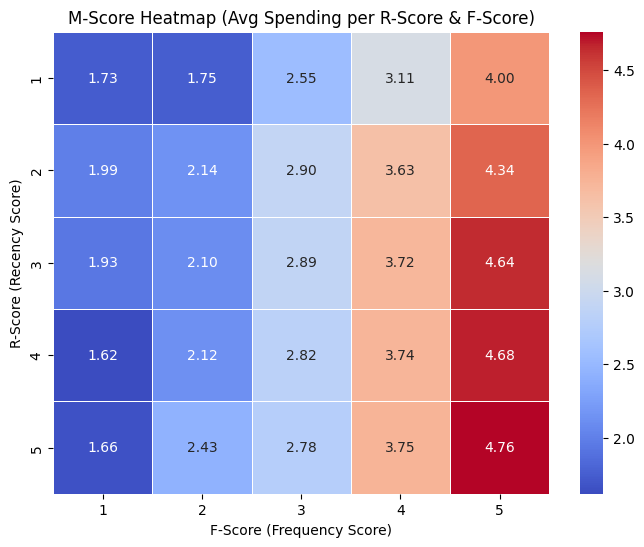

In [145]:
# Plotting the Pivot on the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data=rfm_pivot,cmap='coolwarm',annot=True, fmt='.2f',linewidths=0.5)

# Labels and title
plt.title('M-Score Heatmap (Avg Spending per R-Score & F-Score)')
plt.xlabel('F-Score (Frequency Score)')
plt.ylabel('R-Score (Recency Score)')

plt.savefig('heatmap.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [146]:
# Pivoting the RFM by count
rfm_pivot = rfm_df.pivot_table(index='R_Score',columns='F_Score',values='M_Score',aggfunc='count',fill_value=0)
rfm_pivot

F_Score,1,2,3,4,5
R_Score,,,,,
1,362,307,138,47,13
2,199,199,227,163,50
3,165,182,188,208,117
4,97,121,177,249,244
5,44,58,137,200,443


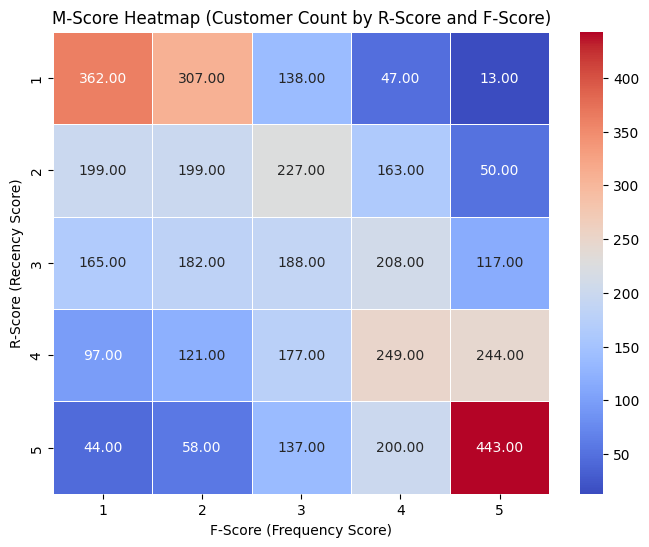

In [148]:
#Plotting the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data=rfm_pivot, cmap='coolwarm',annot=True, fmt='.2f',linewidths=0.5)

#Labels and title
plt.title('M-Score Heatmap (Customer Count by R-Score and F-Score)')
plt.xlabel('F-Score (Frequency Score)')
plt.ylabel('R-Score (Recency Score)')
plt.show()

### Advance Analysis
Finding out the type of the customers ('New','Churned','Returning') based on their purchase

In [179]:
# Creating a new dataframe from the original one for the analysis
df_new = df.copy()

In [180]:
df_new.shape

(391183, 10)

In [181]:
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,DayOfWeek
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday


In [182]:
print(df_new['InvoiceDate'].dtype)

datetime64[ns]


In [183]:
# Extract the Year-Month for analysis
df_new['PurchaseMonth'] = df_new['InvoiceDate'].dt.to_period('M')

In [184]:
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,DayOfWeek,PurchaseMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Wednesday,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Wednesday,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,2010-12


In [186]:
# Get the first purchase month per customer
first_purchase = df_new.groupby('CustomerID')['PurchaseMonth'].min().reset_index()
first_purchase.rename(columns={'PurchaseMonth': 'FirstPurchaseMonth'}, inplace=True)

In [187]:
first_purchase.head()

,CustomerID,FirstPurchaseMonth
0,12346.0,2011-01
1,12347.0,2010-12
2,12348.0,2010-12
3,12349.0,2011-11
4,12350.0,2011-02


In [188]:
# Merge the first_purchase df with the df_new
df_new = df_new.merge(first_purchase, on='CustomerID',how='left')
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,DayOfWeek,PurchaseMonth,FirstPurchaseMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Wednesday,2010-12,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,2010-12,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Wednesday,2010-12,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,2010-12,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,2010-12,2010-12


In [189]:
# Define the churn threshold (90 days of inactivity)
churn_threshold = 90

In [190]:
# Function to classify the type of customer based on Firstpurchase
def customer_type(row):
    if row['PurchaseMonth'] == row['FirstPurchaseMonth']:
        return 'New Customer'
    elif (df_new['InvoiceDate'].max() - row['InvoiceDate']).days > churn_threshold:
        return 'Churned Customer'
    else:
        return 'Returning Customer'

In [191]:
# Apply the function 
df_new['CustomerType'] = df_new.apply(customer_type,axis=1)

In [192]:
df_new[['CustomerID', 'InvoiceDate', 'PurchaseMonth', 'CustomerType']].head()

,CustomerID,InvoiceDate,PurchaseMonth,CustomerType
0,17850.0,2010-12-01 08:26:00,2010-12,New Customer
1,17850.0,2010-12-01 08:26:00,2010-12,New Customer
2,17850.0,2010-12-01 08:26:00,2010-12,New Customer
3,17850.0,2010-12-01 08:26:00,2010-12,New Customer
4,17850.0,2010-12-01 08:26:00,2010-12,New Customer


In [195]:
# Analysing the customer trends
customer_trends = df_new.groupby(['PurchaseMonth', 'CustomerType'])['CustomerID'].nunique().reset_index()
customer_trends.rename(columns={'CustomerID': 'CustomerCount'}, inplace=True)
customer_trends.head()

,PurchaseMonth,CustomerType,CustomerCount
0,2010-12,New Customer,884
1,2011-01,Churned Customer,323
2,2011-01,New Customer,416
3,2011-02,Churned Customer,377
4,2011-02,New Customer,380


In [196]:
# Convert the purchase month to str for better plotting
customer_trends['PurchaseMonth'] = customer_trends['PurchaseMonth'].astype('str')

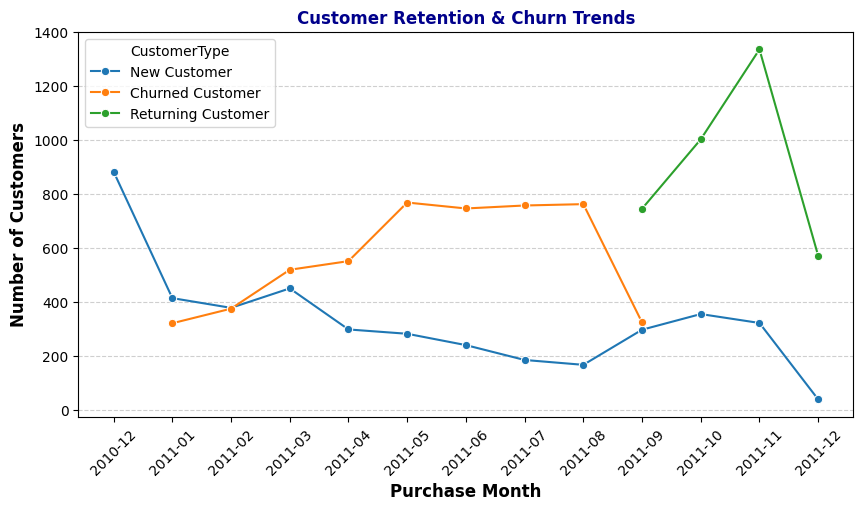

In [200]:
# Plot the type of customers based on purchase mont
plt.figure(figsize=(10,5))

# line plot
sns.lineplot(data=customer_trends,x='PurchaseMonth', y='CustomerCount', hue='CustomerType',marker='o')

# Formatting
plt.title('Customer Retention & Churn Trends', fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel('Purchase Month', fontsize=12, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=12, fontweight='bold')
plt.legend(title='CustomerType')
plt.xticks(rotation=45)
plt.grid(axis='y',linestyle='--',alpha=0.6)

plt.show()

### Exporting the Datasets

In [201]:
df.to_csv('../Dataset/df_cleaned.csv',index=False)
rfm_df.to_csv('../Dataset/rfm_new_data.csv',index=False)
df_new.to_csv('../Dataset/df_customer_type.csv',index=False)